# Topic Models 1 - Comparison of Topic Models

This notebook explores a number of topic modelling algorithms within Gensim and compares them using the coherence measure.

* Section 1 - Import libraries and dataset
* Section 2 - Data cleaning and pre-processing
* Section 3 - Set up Gensim Model
* Section 4 - Comparison of Models - LSI, LDA and NMF
* Section 5 - Running the Gensim LDA model
* Section 6 - Running and evaluating Scikit learn NMF models

Dataset need to run notebook:

* noun_phrase_exploded.csv

Data saved to:

* topicmodelsaccom.csv
* topicmodelsfood.csv
* topicmodelsattract.csv


# Section 1: Import Libraries and Dataset

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.util import ngrams
import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel,Phrases
from gensim.corpora import Dictionary
from gensim.models.nmf import Nmf as GensimNmf
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import pyLDAvis.sklearn
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter
import ast
import pickle
import warnings
import re
warnings.filterwarnings("ignore")
import os
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\imoge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\imoge\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [186]:
# Bring in data from the aspect extraction - keywords notebook
df = pd.read_csv("noun_phrase_exploded.csv")
df.drop(columns = ["Unnamed: 0"],axis = 1,inplace = True)
df.drop(columns = ["len"],axis = 1,inplace = True)
df.head(2)

,OrigInd,Category,Town,Rating,all_text,sentences,cleaned_sentences,noun_phrases
0,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...","Nice break, shame about the accommodation... W...",nice break shame accommodation booked night st...,shame accommodation
1,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...","Nice break, shame about the accommodation... W...",nice break shame accommodation booked night st...,night stay december post-christmas


In [187]:
df.columns

Index(['OrigInd', 'Category', 'Town', 'Rating', 'all_text', 'sentences',
       'cleaned_sentences', 'noun_phrases'],
      dtype='object')

In [188]:
df[["OrigInd","cleaned_sentences","noun_phrases"]].head(10)

,OrigInd,cleaned_sentences,noun_phrases
0,0,nice break shame accommodation booked night st...,shame accommodation
1,0,nice break shame accommodation booked night st...,night stay december post-christmas
2,0,nice break shame accommodation booked night st...,family adult kid
3,0,would never not really sure expect review eith...,good terrible
4,0,would never not really sure expect review eith...,usual choice
5,0,first impression not good we arrived parked ca...,car park
6,0,first impression not good we arrived parked ca...,apartment furthest distance
7,0,bearing mind people apartment obviously self-c...,mind people apartment
8,0,bearing mind people apartment obviously self-c...,ton stuff haul room
9,0,bearing mind people apartment obviously self-c...,available nearer part resort


# Section 2: Data Cleaning and Pre-processing

In [189]:
# Get parts of speech, noun phrases and nouns
df['pos'] = df["noun_phrases"].apply(lambda x:nltk.tag.pos_tag(x.split()))
df['nouns'] = df['pos'].apply(lambda x: [i[0] for i in x if i[1].startswith('N')])

In [190]:
tokens = nltk.word_tokenize("hot delicious")
nltk.pos_tag(tokens)

[('hot', 'JJ'), ('delicious', 'JJ')]

In [191]:
# Look at examples - nouns are effectively fine-grained aspects
df[["cleaned_sentences","noun_phrases","nouns"]].head()

,cleaned_sentences,noun_phrases,nouns
0,nice break shame accommodation booked night st...,shame accommodation,"[shame, accommodation]"
1,nice break shame accommodation booked night st...,night stay december post-christmas,"[night, post-christmas]"
2,nice break shame accommodation booked night st...,family adult kid,"[family, adult, kid]"
3,would never not really sure expect review eith...,good terrible,[terrible]
4,would never not really sure expect review eith...,usual choice,[choice]


In [192]:
# Check to find how many rows have empty lists
result = df[df.astype(str)['nouns'] == '[]']
result.shape

(1225, 10)

In [193]:
# Have a look at what words are causing the problems - basically implicit aspects
result[["all_text","cleaned_sentences","noun_phrases","pos","nouns"]].sample(10)

,all_text,cleaned_sentences,noun_phrases,pos,nouns
32308,Lovely Dinner!!! and great service from Donna!...,great dinner lovely atmosphere,lovely atmosphere,"[(lovely, RB), (atmosphere, JJ)]",[]
29342,"Gave Vintage Inns a second chance, we weren’t ...",starter delicious scallop chorizo novel dough ...,lovely plentiful,"[(lovely, RB), (plentiful, JJ)]",[]
79140,Friendly and helpful Four of us older folk dec...,friendly helpful four u older folk decided try...,friendly helpful,"[(friendly, RB), (helpful, JJ)]",[]
20419,Ok We had a good bison burger. But the cod and...,pleasant service nice atmosphere,nice atmosphere,"[(nice, RB), (atmosphere, RB)]",[]
29944,Awesome Cafe Both the service and food was sub...,dish fresh hot delicious,fresh hot delicious,"[(fresh, JJ), (hot, JJ), (delicious, JJ)]",[]
68753,Great little takeaway place My husband and I w...,great little takeaway place husband visiting c...,lovely little cafe,"[(lovely, RB), (little, JJ), (cafe, JJ)]",[]
47570,Wonderful service and very good menu If you lo...,flavour good thoroughly enjoyed squid starter ...,flavour good,"[(flavour, RB), (good, JJ)]",[]
68240,Cute bar but poor food We came in to have a fi...,fish finger sandwich cost pretty disappointing...,pretty disappointing garnish,"[(pretty, RB), (disappointing, JJ), (garnish, ...",[]
78015,Lovely beach The beach is fine but people shou...,lovely beach beach fine people aware pebble no...,aware pebble,"[(aware, JJ), (pebble, JJ)]",[]
68423,Under New Management Been going here for few ...,not returning bottom find new chippy,new chippy,"[(new, JJ), (chippy, JJ)]",[]


In [194]:
# Analyse
result["test"] = result["noun_phrases"].apply(lambda x: x.split())
result["combined"] = result["test"].apply(lambda x: ngrams(x,2))
result["word_count"] = result["combined"].apply(Counter)
result_df = pd.DataFrame(result["word_count"].sum().most_common(),columns = ["Word","Count"])

In [195]:
result_df.sort_values(by = "Count",ascending = False).head(10)

,Word,Count
0,"(friendly, helpful)",262
1,"(lovely, atmosphere)",61
2,"(friendly, attentive)",54
3,"(nice, atmosphere)",45
4,"(lovely, evening)",42
5,"(friendly, polite)",25
6,"(friendly, atmosphere)",24
7,"(lovely, touch)",20
8,"(lovely, setting)",17
9,"(lovely, cafe)",14


The most common words appear to be combinations of two adjectives 'friendly helpful', or instances where a word is not correctly recognised as a noun 'lovely evening' or 'lovely setting'. The term 'friendly helpful' is clearly talking about staff but this word is not present in the noun-phrase, possibly because it is caught up within the previous noun-phrase for this sentence in the overall review. These are in effect implicit aspects.

The cases where the second word is not recognised as a noun could be corrected fairly easily. However, the phrases comprised of two adjectives or a verb and adjective or verb and verb are more tricky.

Decision made to drop these items from the data

In [196]:
# Drop empty lists
df2 = df[df.astype(str)['nouns'] != '[]']
df2.drop(columns = ["pos"],axis = 1,inplace = True)
df2.shape

(79073, 9)

In [197]:
# Split into categories
dfaccom = df2[df2["Category"]=="Accommodation"]
dffood = df2[df2["Category"]=="Food"]
dfattract = df2[df2["Category"] =="Attractions"]
print(dfaccom.shape,dffood.shape,dfattract.shape)

(26664, 9) (44047, 9) (8362, 9)


In [222]:
# Extract a 10% sample to test the topic models
def samp(df):
    s = np.random.rand(len(df)) < 0.9
    df_train = df[s]
    df_test = df[~s]
    return df_train,df_test

In [223]:
# Run function
train_test_accom = samp(dfaccom)
train_test_food = samp(dffood)
train_test_attract = samp(dfattract)

In [224]:
# Extract training and test sets
df_accom = train_test_accom[0]
df_food = train_test_food[0]
df_attract = train_test_attract[0]

df_accom_test = train_test_accom[1]
df_food_test = train_test_food[1]
df_attract_test = train_test_attract[1]

In [225]:
# Extract nouns from training and test sets
accom_nouns = df_accom["nouns"]
food_nouns = df_food["nouns"]
attract_nouns = df_attract["nouns"]

accom_nouns_test = df_accom_test["nouns"]
food_nouns_test = df_food_test["nouns"]
attract_nouns_test = df_attract_test["nouns"]

In [226]:
print(accom_nouns.shape,food_nouns.shape,attract_nouns.shape)
print(accom_nouns_test.shape,food_nouns_test.shape,attract_nouns.shape)

(23979,) (39687,) (7506,)
(2685,) (4360,) (7506,)


In [227]:
attract_nouns.head(10)

71828            [garden, winter]
71830             [garden, visit]
71831                    [autumn]
71832            [plenty, flower]
71833    [ground, wonder, behold]
71834                    [garden]
71835                [experience]
71836              [latte, taste]
71837                     [water]
71838                     [stale]
Name: nouns, dtype: object

In [228]:
# Implode dataframe back to sentence level from noun phrase level
#df_comb = df.groupby(["OrigInd","Category","Town","Rating","all_text","sentences","cleaned_sentences"]).agg({'noun_phrases':lambda x: " ".join(x)}).rename({'noun_phrases':'sentence'},axis = 1).reset_index()
#df_comb.drop(columns = ["sentence"],axis = 1,inplace = True)

# Section 3: Create BOW and Dictionaries for Gensim Topic Model

Note: Gensim is used as it is easier to compare models using coherence and much quicker to run on larger datasets with limited compute resources

In [229]:
# Functions to extract bigrams
def make_bigrams(texts):
    bigram = gensim.models.Phrases(texts,min_count = 1,threshold = 1)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in texts]

In [230]:
# Run function for training set
accom_nouns_bigrams = make_bigrams(accom_nouns)
food_nouns_bigrams = make_bigrams(food_nouns)
attract_nouns_bigrams = make_bigrams(attract_nouns)

# Run function for test set
accom_test_bigrams = make_bigrams(accom_nouns_test)
food_test_bigrams = make_bigrams(food_nouns_test)
attract_test_bigrams = make_bigrams(attract_nouns_test)

In [231]:
# Print first ten items of bigrams
print(food_nouns_bigrams[20:30])

[['food', 'service'], ['setting'], ['dinner', 'eaten'], ['fruit', 'watery', 'base'], ['porridge', 'oat'], ['couple_table'], ['group'], ['plate', 'rest'], ['job'], ['member_group']]


In [232]:
# Function to create dictionary and bow corpus for each category, filtering words that occur in more than 98% 
# documents and less than 2 documents, keep n = None to keep all the tokens in the dictionary as the dataset is pruned to just nouns anyway.

def run_topic(df):
    dictionary = gensim.corpora.Dictionary(df)
    dictionary.filter_extremes(no_below = 0.98, no_above = 2, keep_n = None)
    bow_corpus = [dictionary.doc2bow(doc) for doc in df]
    return dictionary,bow_corpus


In [233]:
# Create dictionaries and corpi for unigrams
accom_dict, accom_bow = run_topic(accom_nouns)
food_dict, food_bow = run_topic(food_nouns)
attract_dict, attract_bow = run_topic(attract_nouns)

In [234]:
print(len(accom_dict),len(food_dict),len(attract_dict))

4613 5620 2704


In [235]:
# Create dictionaries and corpi for bigrams
accom_dict_big, accom_bow_big = run_topic(accom_nouns_bigrams)
food_dict_big, food_bow_big = run_topic(food_nouns_bigrams)
attract_dict_big, attract_bow_big = run_topic(attract_nouns_bigrams)

In [236]:
# Look at an example item with word and frequencies
print([[(food_dict[id], freq) for id, freq in cp] for cp in food_bow[:10]])

[[('location', 1)], [('decor', 1)], [('frites', 1), ('pie', 1), ('steak', 1)], [('aubergine', 1), ('curry', 1)], [('curry', 1), ('problem', 1)], [('food', 1), ('quality', 1), ('review', 1)], [('bit', 1), ('competent', 1), ('mash', 1), ('menu', 1)], [('food', 1), ('quality', 1)], [('lack', 1), ('specialisation', 1)], [('attentive', 1), ('staff', 1)]]


# Section 4: Comparing Gensim Bigram Models with 10 topics

### Latent Semantic Indexing

In [237]:
# Set random number of topics as a starting point to compare the gensim models
num_topics = 10

In [238]:
# Function to run LSI Model
def lsi(corpus, num_topics,dictionary):
    lsi_model = LsiModel(corpus = corpus,num_topics = num_topics, id2word = dictionary, chunksize = 500)
    return lsi_model

In [239]:
# run function for each category
lsi_accom = lsi(accom_bow_big, num_topics, accom_dict_big)
lsi_food = lsi(food_bow_big, num_topics, food_dict_big)
lsi_attract = lsi(attract_bow_big, num_topics, attract_dict_big)

In [240]:
# Show topics as a list - uncomment to show
lsi_accom_topics = lsi_accom.show_topics(formatted = False)
lsi_food_topics = lsi_food.show_topics(formatted = False)
lsi_attract_topics = lsi_attract.show_topics(formatted = False)

### Latent Dirchlet Allocation

In [241]:
# Define model
def lda(corpus, dictionary, num_topics):
    lda_model = LdaModel(corpus = corpus, num_topics=num_topics, id2word=dictionary,random_state = 42)
    return lda_model

In [242]:
# Run models for each category
lda_accom = lda(accom_bow_big, accom_dict_big,num_topics)
lda_food = lda(food_bow_big, food_dict_big,num_topics)
lda_attract = lda(attract_bow_big, attract_dict_big,num_topics)

In [243]:
# Show topics - uncomment to run
lda_accom_topics = lda_accom.show_topics(formatted = False)
lda_food_topics = lda_food.show_topics(formatted = False)
lda_attract_topics = lda_attract.show_topics(formatted = False)

### Non-negative Matrix Factorisation

In [244]:
# Function to run NMF Model
def nmf(corpus, dictionary,num_topics):
    nmf_model = GensimNmf(corpus = corpus, id2word = dictionary,num_topics = num_topics)
    return nmf_model

In [245]:
# run function for each category
nmf_accom = nmf(accom_bow_big, accom_dict_big,num_topics)
nmf_food = nmf(food_bow_big, food_dict_big,num_topics)
nmf_attract = nmf(attract_bow_big, attract_dict_big,num_topics)

In [246]:
# Show topics - uncomment to run
nmf_accom_topics = nmf_accom.show_topics(formatted = False)
nmf_food_topics = nmf_food.show_topics(formatted = False)
nmf_attract_topics = nmf_attract.show_topics(formatted = False)

### Comparison of models with random 5 topics for all models and categories

In [247]:
# Function to get coherence for each model on the top ten topic words using a standard 5 topics
def evaluate(model,model_topics,text,dictionary):
    model_topics = model.show_topics(formatted = False)
    model_topics = [[word for word, prob in topic] for topicid,topic in model_topics]
    model_coherence = CoherenceModel(topics = model_topics[:10],texts = text, dictionary = dictionary,window_size = 10).get_coherence()
    return model_coherence

In [248]:
# Run function for LSI
lsi_accom_eval = evaluate(lsi_accom,lsi_accom_topics,accom_nouns_bigrams,accom_dict_big)
lsi_food_eval = evaluate(lsi_food,lsi_food_topics,food_nouns_bigrams,food_dict_big)
lsi_attract_eval = evaluate(lsi_attract,lsi_attract_topics,attract_nouns_bigrams, attract_dict_big)

In [249]:
# Run function for LDA
lda_accom_eval = evaluate(lda_accom,lda_accom_topics,accom_nouns_bigrams,accom_dict_big)
lda_food_eval = evaluate(lda_food,lda_food_topics,food_nouns_bigrams,food_dict_big)
lda_attract_eval = evaluate(lda_attract,lda_attract_topics,attract_nouns_bigrams,attract_dict_big)

In [250]:
# Run function for NMF
nmf_accom_eval = evaluate(nmf_accom,nmf_accom_topics,accom_nouns_bigrams,accom_dict_big)
nmf_food_eval = evaluate(nmf_food, nmf_food_topics,food_nouns_bigrams,food_dict_big)
nmf_attract_eval = evaluate(nmf_attract,nmf_attract_topics,attract_nouns_bigrams,attract_dict_big)

In [251]:
# Function to graph results
def graph(coherences,indices,name):
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    fig, ax = plt.subplots()
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_facecolor("White")
    ax.bar(x,coherences,width = 0.5,tick_label=indices,align = 'center',color = "lightsteelblue",ec = "grey")
    ax.set_title("Topic Models Average Coherence Comparison: " + name,fontsize = 10,pad = 15)
    ax.set_xlabel('Models',labelpad = 10)
    ax.set_ylabel('Coherence Value',labelpad = 10)

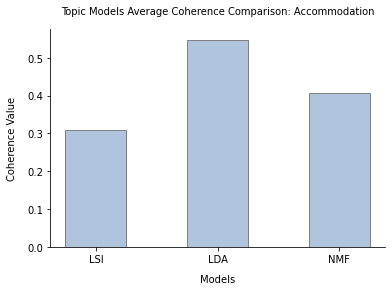

In [252]:
# Run function for accommodation
graph([lsi_accom_eval,lda_accom_eval, nmf_accom_eval],['LSI','LDA','NMF'],"Accommodation")

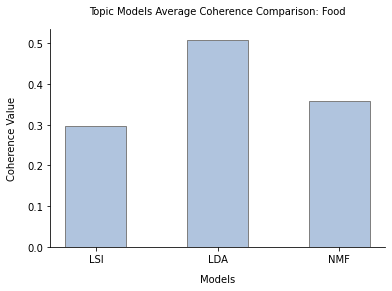

In [253]:
# Run function for food
graph([lsi_food_eval,lda_food_eval, nmf_food_eval],['LSI','LDA','NMF'],"Food")

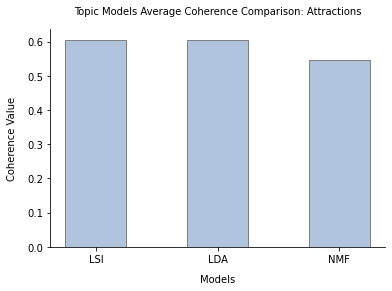

In [254]:
# Run function for attractions
graph([lda_attract_eval,lda_attract_eval, nmf_attract_eval],['LSI','LDA','NMF'],"Attractions")

Comment - LDA appears to offer the highest coherence for each category

# Section 5: Gensim LDA and NMF Models

## Get optimum number of topics

In [255]:
# Function to collect topic coherence and respective weights over a range of topic numbers [COMMENTED OUT BELOW AS TAKES 1 HOUR TO RUN]

def results(model,dictionary, corpus, texts):
    
    # Get coherence values
    cv = []
    tm_list = []
    for num_topics in range(2,50+1,2):
        tm = model(corpus = corpus, num_topics = num_topics, id2word = dictionary)
        tm_list.append(tm)
        cm = CoherenceModel(model = tm, texts = texts, dictionary = dictionary, coherence = 'c_v')
        cv.append(cm.get_coherence())
        
    return cv

In [256]:
# Graph results
def graph_results(cv,name,num):
    
    x = range(2,50+1,2)
    fig, ax = plt.subplots()
    ax.set_facecolor("White")
    ax.plot(x,cv)
    ax.set_xlabel("Number of Topics")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.axvline(num,color = "grey",linestyle = "--",linewidth = 1)
    ax.set_ylabel("Coherence Score")
    ax.legend(("c_v"), loc = 'best',bbox_to_anchor=(1.0,1.0),frameon = False)
    ax.set_title("Coherence Values By Number of Topics:" + name,fontsize = 11)
    plt.show()

#### Accommodation

In [257]:
# run function for accommodation reviews - uncomment to run as takes a long time
#cv_lda = results(LdaModel,accom_dict_big,accom_bow_big,accom_nouns_bigrams)
#cv_nmf = results(GensimNmf,accom_dict_big,accom_bow_big,accom_nouns_bigrams)

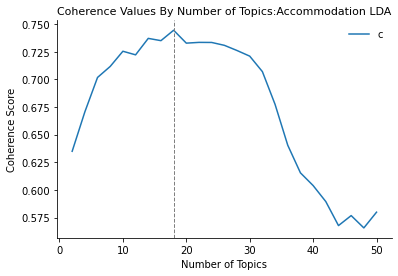

In [269]:
#graph_results(cv_lda,"Accommodation LDA",18)

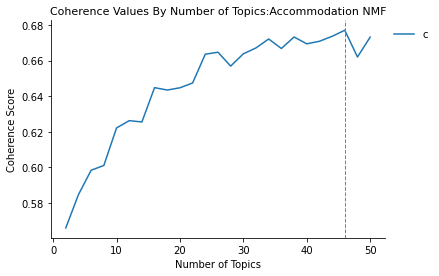

In [271]:
#graph_results(cv_nmf,"Accommodation NMF",46)

#### Food

In [260]:
# run function for food reviews - uncomment to run as takes a long time
#cv_lda2 = results(LdaModel,food_dict_big,food_bow_big,food_nouns_bigrams)
#cv_nmf2 = results(GensimNmf, food_dict_big,food_bow_big,food_nouns_bigrams)

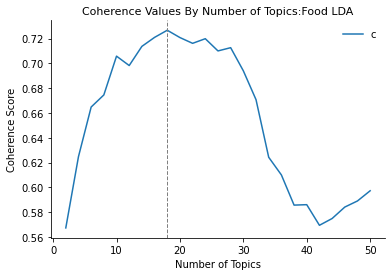

In [272]:
#graph_results(cv_lda2,"Food LDA",18)

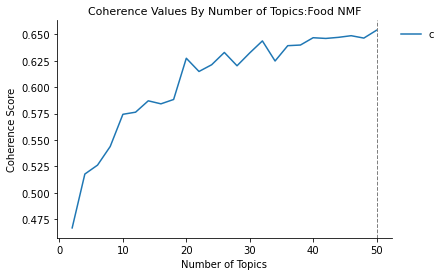

In [273]:
#graph_results(cv_nmf2,"Food NMF",50)

#### Attractions

In [263]:
# run function for attraction reviews - uncomment to run as takes a long time
#cv_lda3 = results(LdaModel,attract_dict_big,attract_bow_big,attract_nouns_bigrams)
#cv_nmf3 = results(GensimNmf,attract_dict_big,attract_bow_big,attract_nouns_bigrams)

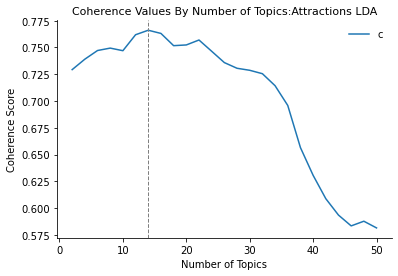

In [276]:
#graph_results(cv_lda3,"Attractions LDA",14)

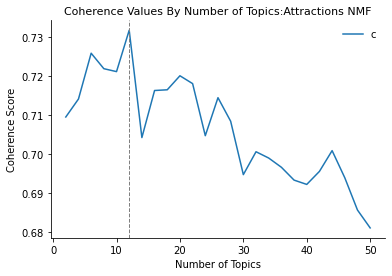

In [277]:
#graph_results(cv_nmf3,"Attractions NMF",12)

## Implement Gensim LDA Model

In [282]:
# Function to run gensim lda
def lda_mod(corpus,n,dict):
    lda_model = LdaModel(corpus = corpus, num_topics=n, id2word=dict, passes=20)
    topics = lda_model.print_topics(num_words = 3)
    return topics,lda_model

In [283]:
# Run function using the highest topic coherence from the section above
lda_accom = lda_mod(accom_bow_big,18,accom_dict_big)
lda_food = lda_mod(food_bow_big,18,food_dict_big)
lda_attract = lda_mod(attract_bow_big,14,attract_dict_big)

In [284]:
# Print top 3 words for each topic in each category
lda_accom[0]

[(0, '0.099*"need" + 0.067*"plenty" + 0.051*"trip"'),
 (1, '0.122*"site" + 0.103*"people" + 0.087*"shower"'),
 (2, '0.134*"visit" + 0.043*"fun" + 0.043*"issue"'),
 (3, '0.108*"kid" + 0.105*"experience" + 0.065*"way"'),
 (4, '0.105*"house" + 0.075*"thing" + 0.066*"day"'),
 (5, '0.081*"facility" + 0.080*"stay" + 0.056*"lunch"'),
 (6, '0.136*"child" + 0.075*"door" + 0.060*"apartment"'),
 (7, '0.324*"breakfast" + 0.058*"floor" + 0.038*"tea_coffee"'),
 (8, '0.071*"time" + 0.061*"friend" + 0.059*"side"'),
 (9, '0.158*"service" + 0.149*"location" + 0.106*"weekend"'),
 (10, '0.305*"staff" + 0.176*"food" + 0.079*"pub"'),
 (11, '0.356*"hotel" + 0.120*"place" + 0.046*"tidy"'),
 (12, '0.116*"meal" + 0.081*"value_money" + 0.066*"road"'),
 (13, '0.210*"night" + 0.129*"family" + 0.058*"dinner"'),
 (14, '0.503*"room" + 0.095*"area" + 0.031*"bedroom"'),
 (15, '0.087*"value" + 0.073*"beach" + 0.054*"size"'),
 (16, '0.182*"bed" + 0.122*"pool" + 0.081*"view"'),
 (17, '0.161*"restaurant" + 0.085*"walk" + 0

In [285]:
lda_food[0]

[(0, '0.173*"price" + 0.105*"bit" + 0.054*"need"'),
 (1, '0.085*"selection" + 0.078*"owner" + 0.067*"waitress"'),
 (2, '0.127*"tasty" + 0.078*"sunday_lunch" + 0.069*"plate"'),
 (3, '0.278*"lunch" + 0.207*"visit" + 0.045*"venue"'),
 (4, '0.511*"staff" + 0.080*"course" + 0.042*"look"'),
 (5, '0.201*"menu" + 0.077*"value_money" + 0.061*"pizza"'),
 (6, '0.182*"pub" + 0.138*"experience" + 0.092*"evening"'),
 (7, '0.142*"choice" + 0.140*"drink" + 0.105*"table"'),
 (8, '0.207*"chip" + 0.057*"thing" + 0.054*"cake"'),
 (9, '0.240*"meal" + 0.232*"restaurant" + 0.098*"breakfast"'),
 (10, '0.152*"portion" + 0.070*"beer" + 0.059*"option"'),
 (11, '0.335*"place" + 0.120*"value" + 0.084*"people"'),
 (12, '0.119*"area" + 0.069*"wine" + 0.049*"sunday"'),
 (13, '0.075*"u" + 0.049*"superb" + 0.048*"child"'),
 (14, '0.143*"family" + 0.133*"order" + 0.055*"sauce"'),
 (15, '0.534*"food" + 0.275*"service" + 0.051*"quality"'),
 (16, '0.130*"night" + 0.071*"atmosphere" + 0.071*"customer"'),
 (17, '0.113*"frien

In [286]:
lda_attract[0]

[(0, '0.104*"park" + 0.062*"view" + 0.043*"show"'),
 (1, '0.086*"price" + 0.052*"thing" + 0.050*"part"'),
 (2, '0.054*"building" + 0.034*"event" + 0.033*"photo"'),
 (3, '0.129*"garden" + 0.086*"shop" + 0.054*"hour"'),
 (4, '0.106*"beach" + 0.091*"walk" + 0.049*"fun"'),
 (5, '0.047*"play" + 0.040*"age" + 0.035*"money"'),
 (6, '0.100*"lot" + 0.033*"lunch" + 0.031*"space"'),
 (7, '0.077*"town" + 0.042*"year" + 0.041*"pool"'),
 (8, '0.064*"history" + 0.052*"look" + 0.045*"service"'),
 (9, '0.209*"place" + 0.106*"experience" + 0.079*"child"'),
 (10, '0.134*"staff" + 0.098*"area" + 0.069*"way"'),
 (11, '0.075*"room" + 0.052*"car_park" + 0.046*"cinema"'),
 (12, '0.249*"visit" + 0.095*"family" + 0.069*"cafe"'),
 (13, '0.105*"food" + 0.071*"people" + 0.061*"value"')]

## Generate perplexity scores

In [287]:
# Generate perplexity - looking for low perplexity
def perp(lda,corpus):
    print('Perplexity:', lda.log_perplexity(corpus))

In [288]:
perp(lda_accom[1],accom_bow_big)
perp(lda_food[1],food_bow_big)
perp(lda_attract[1],attract_bow_big)

Perplexity: -15.278578591371147
Perplexity: -15.15779718586759
Perplexity: -12.15372783852275


In [289]:
# Coherence - as per the graph for the chosen number of topics
def coher(lda,text,d):
    coherence_score_lda = CoherenceModel(model = lda,texts = text,dictionary = d,coherence = 'c_v')
    coherence_score = coherence_score_lda.get_coherence()
    print('Coherence:', coherence_score)

In [290]:
coher(lda_accom[1],accom_nouns_bigrams,accom_dict_big)
coher(lda_food[1],food_nouns_bigrams,food_dict_big)
coher(lda_attract[1],attract_nouns_bigrams,attract_dict_big)

Coherence: 0.7385968458004495
Coherence: 0.7249037514168841
Coherence: 0.7500233422853633


## Visualising the models

In [291]:
# Function to run pyLDAvis
def vis(lda_model,bow_corpus,gen_dict):
    lda_vis = gensimvis.prepare(lda_model, bow_corpus, gen_dict,sort_topics = False)
    return lda_vis

In [292]:
vis(lda_accom[1],accom_bow_big,accom_dict_big)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.061719 -0.008304       1        1  4.728951
1     -0.052400 -0.007350       2        1  5.157377
2     -0.053099 -0.007426       3        1  5.172640
3     -0.059340 -0.008070       4        1  4.950685
4     -0.059781 -0.008116       5        1  4.855117
5     -0.018028 -0.002944       6        1  5.864786
6     -0.065411 -0.008642       7        1  4.825035
7     -0.035714 -0.005376       8        1  5.338896
8     -0.059001 -0.008038       9        1  5.034650
9      0.009520  0.001659      10        1  6.079062
10     0.216574  0.296396      11        1  6.900775
11     0.164878  0.089505      12        1  7.086036
12    -0.043183 -0.006304      13        1  5.036255
13    -0.030190 -0.004658      14        1  5.938983
14     0.286912 -0.292367      15        1  7.215186
15    -0.059499 -0.008089      16        1  4.925565
16    -0.045182 -0.006538      17        1  5.350100
17    -0.035335 -0.005336      18        1  5.539902, topic_info=                Term         Freq        Total Category  logprob  loglift
11              room  1515.000000  1515.000000  Default  30.0000  30.0000
150            hotel  1055.000000  1055.000000  Default  29.0000  29.0000
142            staff   879.000000   879.000000  Default  28.0000  28.0000
301        breakfast   723.000000   723.000000  Default  27.0000  27.0000
66             night   521.000000   521.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
212       glass_wine    13.085134    14.317165  Topic18  -5.1752   2.8032
1429            bill    11.600979    12.833009  Topic18  -5.2956   2.7923
538   gold_apartment    10.551655    11.783685  Topic18  -5.3904   2.7828
1374       situation     9.456776    10.688806  Topic18  -5.5000   2.7707
1219          silver     8.571664     9.803695  Topic18  -5.5982   2.7589

[570 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
880      18  0.988556         access
0        10  0.992400  accommodation
473      10  0.948778            act
234       9  0.986728       activity
761      15  0.804261       addition
...     ...       ...            ...
784      17  0.936044          world
865      14  0.937249            wow
343      18  0.992130           year
49       16  0.956253            yes
1161      8  0.898914          youth

[540 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

In [293]:
vis(lda_food[1],food_bow_big,food_dict_big)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.026240 -0.018692       1        1  5.321739
1      0.043907 -0.024814       2        1  4.993167
2      0.052594 -0.026689       3        1  4.620828
3      0.030045 -0.019950       4        1  5.284981
4      0.010483 -0.010450       5        1  5.482198
5      0.016085 -0.013957       6        1  5.549821
6      0.032650 -0.021089       7        1  5.297649
7      0.040393 -0.023542       8        1  5.221175
8      0.032906 -0.021191       9        1  5.230580
9     -0.075826  0.419010      10        1  7.355962
10     0.045687 -0.025132      11        1  4.705996
11     0.009326 -0.009943      12        1  5.368071
12     0.057921 -0.027671      13        1  4.525204
13     0.034255 -0.021635      14        1  5.211095
14     0.037598 -0.022736      15        1  5.127938
15    -0.444284 -0.098024      16        1  9.793857
16     0.041880 -0.024085      17        1  5.082690
17     0.008143 -0.009411      18        1  5.827048, topic_info=                 Term         Freq        Total Category  logprob  loglift
13               food  3453.000000  3453.000000  Default  30.0000  30.0000
29              staff  1850.000000  1850.000000  Default  29.0000  29.0000
34            service  1780.000000  1780.000000  Default  28.0000  28.0000
191             place  1188.000000  1188.000000  Default  27.0000  27.0000
69               meal  1167.000000  1167.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
1140       staff_rude    22.987261    24.266383  Topic18  -5.1207   2.7885
1202       lot_choice    22.288847    23.567969  Topic18  -5.1516   2.7869
636   friend_birthday    17.912748    19.191870  Topic18  -5.3702   2.7737
1119             meet    17.817318    19.096440  Topic18  -5.3755   2.7733
1054         response    16.023841    17.302963  Topic18  -5.4816   2.7659

[570 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
922       9  0.931211  accommodate
141      14  0.974677        adult
1155     16  0.938207  adult_child
440      10  0.809469    adult_kid
158       3  0.992306    afternoon
...     ...       ...          ...
176       3  0.991012         year
460       7  0.973178          yes
190      10  0.909252      yoghurt
905       5  0.961903    yorkshire
571      17  0.977858        yummy

[540 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

In [294]:
vis(lda_attract[1],attract_bow_big,attract_dict_big)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.032841  0.037305       1        1  7.449307
1      0.031361  0.022934       2        1  7.146584
2      0.026176  0.019155       3        1  5.563747
3      0.028334 -0.354976       4        1  8.316113
4     -0.369683  0.000969       5        1  8.877034
5      0.029591  0.018888       6        1  6.279377
6      0.028669  0.023155       7        1  6.460210
7      0.029619  0.028376       8        1  6.990590
8      0.022081  0.021759       9        1  6.753295
9      0.023670  0.026182      10        1  7.219046
10     0.035147  0.066494      11        1  7.695391
11     0.026686  0.030205      12        1  7.075778
12     0.029224  0.033467      13        1  7.394504
13     0.026285  0.026087      14        1  6.779024, topic_info=             Term        Freq       Total Category  logprob  loglift
2           visit  242.000000  242.000000  Default  30.0000  30.0000
120         place  198.000000  198.000000  Default  29.0000  29.0000
0          garden  142.000000  142.000000  Default  28.0000  28.0000
117         staff  136.000000  136.000000  Default  27.0000  27.0000
1689        beach  124.000000  124.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
508           joy    5.888744    6.859061  Topic14  -5.0173   2.5388
898   waste_money    5.620709    6.591026  Topic14  -5.0639   2.5321
568      property    5.494869    6.465186  Topic14  -5.0865   2.5287
2789  performance    5.266909    6.237456  Topic14  -5.1289   2.5222
330   magnificent    4.492229    5.462546  Topic14  -5.2880   2.4958

[453 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
153       2  0.972240       access
761      13  0.803694  access_area
487       3  0.978363     activity
413       1  0.958860        adult
1047      3  0.881038    adventure
...     ...       ...          ...
1285      2  0.898032     woodland
125      12  0.983386         work
122      10  0.891178        world
20        8  0.982878         year
1155     11  0.917056          yes

[426 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

Analysis
* Using the most coherent topics in the LDA model the visualisation shows that many of the topics for accommodation and food are overlapping, indicating that the model is not performing well.

# Section 6: SciKit Learn NMF Model

* There are no scores available for nmf through sklearn implementation, so the models are run with different topic numbers and the results assessed manually.
* The initial topic numbers are taken from the Gensim LDA model above as a starting point. As the models run very quickly, this can easily be repeated until a satisfactory set of results is derived. 
* The Scikit learn implementation is used as it accepts tf-idf weights as well as term frequencies, TFIDF is used by most as it usually returns the best results since it weights rare words higher and frequent words throughout the corpus lower. 
* However with these very short texts of just a few nouns (ie very processed and cleaned dataset) and adjustments using the vectorizer function, the countvectorizer model may work a little better, so both are compared. 

## Set up countvectorizer and tf-idf vectorizer models

In [295]:
#Convert list of strings to a string for training set
accom_joined = accom_nouns.apply(lambda x:' '.join(x))
food_joined = food_nouns.apply(lambda x:' '.join(x))
attract_joined = attract_nouns.apply(lambda x:' '.join(x))

# Test set
accom_nouns_joined_test = accom_nouns_test.apply(lambda x:' '.join(x))
food_nouns_joined_test = food_nouns_test.apply(lambda x: ' '.join(x))
attract_nouns_joined_test = attract_nouns_test.apply(lambda x:' '.join(x))

In [296]:
# add some words to remove that do not add useful information
sw_accom = ["le","hour","place","lot","bit","get","side","night","stay","week","hour","day","home","weekend","avisford"
            "people","area","holiday","chip","kid","breakfast","pub","dinner","lunch","evening","child","adult","people","avisford"]
sw_food = ["restaurant","chip","review","time","sunday","thing","roast","family","lunch","pub","dinner","breakfast","birthday","evening","place",
          "friend","night","group"]
sw_attract = ["lot","room"]

In [297]:
# Function to transform to bow and tfidf models - Maximum features in the dictionary to be 1000, exclude words occurring in less # than 2 documents 
# and in more than 95% of documents and to include unigrams,bigrams and trigrams. 

def transform(df,sw):
            
    countvectorizer = CountVectorizer(stop_words = sw,max_features = 1500,max_df = 0.95, min_df = 3,ngram_range=(1,3))
    tf_idf_vectorizer = TfidfVectorizer(stop_words = sw,max_features = 1500,max_df = 0.95,min_df = 2,ngram_range=(1, 3))
    vector1 = countvectorizer.fit_transform(df)
    vector2 = tf_idf_vectorizer.fit_transform(df)
    
    
    return countvectorizer,tf_idf_vectorizer,vector1,vector2

In [298]:
# Create vectorizer and tfidf vectorizer objects 
cv_accom,tfidf_accom,vec1_accom,vec2_accom = transform(accom_joined,sw_accom)
cv_food,tfidf_food,vec1_food,vec2_food = transform(food_joined,sw_food)
cv_attract,tfidf_attract,vec1_attract,vec2_attract = transform(attract_joined,sw_attract)

## Fit NMF Model

In [299]:
# NMF function - alpha set to 1.0 for regularization and max_iter to 1000 rather than default of 200, as topics are fuzzy. 
# The model is initialised with Nonnegative Double Singular Value Decomposition (NNDSVD) initialization (better for sparse data) to help convergence. 
# Alpha controls the amount of regularisation to prevent overfitting. The solver used is the default coordinate descent and the optimizer is '
# 'frobenius'(square root of the absolute sum of squares of the elements) and also the default. The maximum iterations is the number before timing out. 
# Shuffle is set to True to shuffle the coordinates in the solver.

# Define and fit model
def nmf(vector,num_topics,vectorizer):
    nmf_model = NMF(n_components = num_topics, 
                    init = 'nndsvd',
                    alpha = 1,
                    solver="cd",
                    beta_loss='frobenius',
                    max_iter = 1000,
                    shuffle=True,
                    random_state = 0)
    
    W = nmf_model.fit_transform(vector) # each column represents the weight of each word in a doc (w)
    H = nmf_model.components_  # each row represents a word embedding (h) and is a weighting

        
    # Extract topics,features and weights
    feature_names = np.array(vectorizer.get_feature_names())
    feature_idxs = np.argsort(-H)
    topics = [feature_names[idx] for idx in feature_idxs]
    topics = pd.DataFrame(topics).T
    topics.columns = ["T" + str(i) for i in range(1,num_topics+1)]
               
    return topics,H,W,nmf_model
               

In [300]:
# Get countvectorizer doc topics, H,W,and nmf fitted model - start with number of topics suggested by LDA model and then adjust to find most coherent topics
accom_count_topics,H_accom,W_accom,count_mod = nmf(vec1_accom,18,cv_accom)

## Run models for accommodation

### Countvectorizer NMF Model - accommodation (using LDA model number of topics)

In [303]:
pd. set_option('display.max_colwidth', 10)
accom_count_topics.head(10)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18
0,room,staff,hotel,food,pool,service,restau...,family,value,park,bed,tea,location,floor,visit,entert...,view,choice
1,hotel ...,member,hotel ...,quality,splash,customer,food r...,family...,money,car,comfy,coffee,town,ground,family...,show,sea,meal
2,room room,helpful,hotel ...,good,splash...,custom...,hotel ...,fun,value ...,car park,comfy bed,tea co...,centre,ground...,year,activity,sea view,plenty
3,shower,reception,hotel ...,food good,wave,guest,site,friend,waste,hotel car,bunk,facility,minute,apartment,visit ...,centre,view room,menu
4,family...,staff ...,room h...,drink,wave pool,food s...,deck,family...,waste ...,hotel ...,bunk bed,coffee...,walk,bathroom,resort,stage,sea vi...,quality
5,size,member...,hotel ...,court,slide,room s...,deck r...,family...,accomm...,water,bed comfy,fridge,beach,floor ...,visit ...,team,balcony,plenty...
6,room s...,recept...,staff ...,qualit...,fun,guest ...,shop,member,price,space,size,tea co...,hotel ...,room g...,return,centre...,room s...,choice...
7,room h...,staff ...,spa,food c...,water,servic...,ate,raft,food v...,road,bathroom,biscuit,shop,room g...,review,fun,room sea,price
8,steam,hotel ...,star,food s...,activity,servic...,diner,family...,pay,park car,size bed,fridge...,locati...,ground...,apartment,skyline,walk,course
9,steam ...,polite,hotel ...,food r...,facility,quality,restau...,group,activity,caravan,sofa,making,conven...,dance,beach,site,front,choice...


Inferring topics can be difficult and should usually be done by domain experts. For the purposes of this project, the topics are inferred by looking at the top 5/10 words.

In [304]:
# Apply inferred topics to documents with the associated weights
pd.options.display.float_format = '{:,.3f}'.format
accom_count_df = pd.DataFrame(W_accom)
accom_count_df.columns = ["RoomGen","Staff","HotelGen","Food","Leisure&Fac","CustomerServ","EatingFac","FamilyFac","VFM","Parking&Other","RoomComf",
                         "RoomFac","HotelLoc","RoomLoc","Visit Exp","Entertainment","Views","MealChoice"]
accom_count_df["Top"] = accom_count_df.idxmax(axis="columns")
#topics_per_doc_accom_count.head()

In [305]:
# Add the most likely countvectorizer topic to the review dataframe
predict_count_accom = pd.DataFrame(df_accom[["OrigInd","Category","Town","Rating","all_text","cleaned_sentences","noun_phrases","nouns"]]).reset_index(drop = True)
accom_predict_count = pd.concat([predict_count_accom,accom_count_df["Top"]],axis = 1,ignore_index = True)
accom_predict_count.columns = ["OrigInd","Category","Town","Rating","all_text","cleaned","noun_phrases","nouns","Topic Count"]
pd.set_option('max_colwidth',40)

In [306]:
#accom_predict_count[["noun_phrases","nouns","Topic Count"]].sample(10)

,noun_phrases,nouns,Topic Count
13018,close location,[location],HotelLoc
18961,turning round dirty table guest,"[round, dirty, table, guest]",CustomerServ
8185,extra hotel room,"[hotel, room]",HotelGen
13787,church farm,"[church, farm]",Visit Exp
4134,mould dirt cobweb everywhere,[cobweb],RoomGen
6796,hi-de-hi experience,[experience],RoomLoc
12561,amazing spa hotel,[hotel],HotelGen
23287,amazing requirement request,"[requirement, request]",RoomLoc
18461,return key card,"[return, card]",Visit Exp
3846,show milkshake daughter,"[show, daughter]",Entertainment


### TFIDF NMF Model - accommodation

In [307]:
# Get countvectorizer doc topics, H,W,and nmf fitted model for tfidf vectorizer
accom_tfidf_topics,H_accom_tfidf,W_accom_tfidf,tfidf_mod = nmf(vec2_accom,18,tfidf_accom)

In [311]:
pd.set_option('display.max_colwidth', 10)
accom_tfidf_topics.head(10)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18
0,room,staff,hotel,food,pool,family,service,bed,restau...,location,visit,value,entert...,park,meal,price,experi...,site
1,hotel ...,member,hotel ...,good,splash,family...,customer,comfy,food r...,town,family...,money,show,car,choice,quality,year,facility
2,family...,helpful,hotel ...,quality,splash...,fun,custom...,comfy bed,hotel ...,hotel ...,return,value ...,fun,car park,course,drink,reception,shop
3,floor,staff ...,room h...,food good,water,friend,food s...,bed comfy,deck r...,locati...,visit ...,waste ...,activity,water,time,choice,need,caravan
4,room room,member...,hotel ...,food r...,wave,family...,room s...,bunk bed,deck,locati...,friend,waste,facility,road,birthday,good,accomm...,tidy
5,room h...,reception,hotel ...,choice,wave pool,family...,guest,bunk,choice,thing,visit ...,accomm...,team,walk,course...,point,daughter,walk
6,room s...,recept...,staff ...,food s...,slide,visit ...,guest ...,size,ate,centre,year,activity,stage,facility,family...,apartment,spa,time
7,view,hotel ...,food h...,qualit...,fun,family...,servic...,sleep,staff ...,beach,apartment,quality,ok,space,morning,fun,rest,shop site
8,shower,staff ...,hotel ...,drink,spa,friend...,servic...,size bed,diner,room l...,tot,food v...,plenty,water ...,door,price ...,floor,restau...
9,bathroom,staff ...,visit ...,food c...,activity,plenty,staff ...,tidy,team,good,resort,pay,entert...,caravan,menu,range,tidy,food site


In [313]:
# Apply inferred topics to documents with the associated weights
pd.options.display.float_format = '{:,.3f}'.format
accom_tfidf_df = pd.DataFrame(W_accom_tfidf)
accom_tfidf_df.columns = ["RoomGen","Staff","HotelGen","Food","Leisure&Fac","FamilyFac","CustomerServ","RoomComf","EatingFac","HotelLoc","Visit Exp","VFM",
                          "Entertainment","Parking&Other", "MealChoice","PriceQual","GenExp","SiteGen"
                          ]
                                                                          
accom_tfidf_df["Top"] = accom_tfidf_df.idxmax(axis="columns")
#topics_per_doc_accom_count.head()

In [314]:
# Add the most likely tfidf topic to the review and conat the two top topics to the original dataframe
predict_tfidf_accom = pd.DataFrame(df_accom[["OrigInd","Town","Rating","all_text","cleaned_sentences","noun_phrases","nouns"]]).reset_index(drop = True)
accom_predict_final = pd.concat([accom_predict_count,accom_tfidf_df["Top"]],axis = 1,ignore_index = True)
accom_predict_final.columns = ["OrigInd","Category","Town","Rating","all_text","cleaned","noun_phrases","nouns","Topic Count","Topic TFIDF"]

In [317]:
pd.set_option('max_colwidth', 30)
accom_predict_final[["noun_phrases","nouns","Topic Count","Topic TFIDF"]].sample(10)

,noun_phrases,nouns,Topic Count,Topic TFIDF
3865,old chair table,"[chair, table]",RoomFac,EatingFac
23561,tea coffee facility,"[tea, coffee, facility]",RoomFac,SiteGen
18160,pate pie terrine ham seafood,"[pate, pie, terrine, ham, ...",MealChoice,MealChoice
21447,unforgivable pub,[pub],RoomGen,RoomGen
21105,great inexpensive bolt hole,"[bolt, hole]",Parking&Other,Parking&Other
19051,hotel oh,"[hotel, oh]",HotelGen,HotelGen
12569,temple spa product,[product],MealChoice,Staff
11857,good the-facilities,[the-facilities],RoomComf,EatingFac
13479,comfortable chair table te...,"[chair, terrace]",RoomFac,Leisure&Fac
17379,need word methinks,"[need, word, methinks]",Entertainment,GenExp


* The countvectorizer model seems to be performing slightly better than the nmf model
* There seem to be some problems with the rows with just one noun which is understandable
* These lines could be dropped from the analysis

In [318]:
# drop rows where there is only one noun
accom_predict_final["len"] = accom_predict_final["nouns"].apply(lambda x: len(x))
greater_one = accom_predict_final[accom_predict_final["len"]>2]
greater_one[["noun_phrases","nouns","Topic Count","Topic TFIDF"]].sample(10)

,noun_phrases,nouns,Topic Count,Topic TFIDF
21187,problem walk gale,"[problem, walk, gale]",HotelLoc,SiteGen
6691,massive choice omelette st...,"[choice, omelette, station...",MealChoice,MealChoice
19997,pool lil bit breakfast,"[pool, lil, bit, breakfast]",Leisure&Fac,Leisure&Fac
15727,whilst business area,"[whilst, business, area]",HotelLoc,SiteGen
823,new pool good splash pool kid,"[pool, splash, pool, kid]",Leisure&Fac,Leisure&Fac
17736,morning elephant room,"[morning, elephant, room]",RoomGen,RoomGen
979,lovely plenty lot team member,"[plenty, lot, team, member]",MealChoice,Entertainment
15721,good value place stay group u,"[value, place, group, u]",VFM,VFM
12650,experience top mark team,"[experience, mark, team]",Entertainment,GenExp
19578,fan kettle stuff,"[fan, kettle, stuff]",RoomFac,RoomGen


* The topics seem a little better

In [319]:
greater_one.shape

(5657, 11)

In [347]:
# Topic distribution in the test set
greater_one["Topic Count"].value_counts()

Entertainment    684
RoomLoc          600
MealChoice       597
RoomGen          464
EatingFac        317
RoomFac          312
Visit Exp        305
FamilyFac        287
Staff            267
HotelLoc         256
Food             253
HotelGen         252
Parking&Other    228
CustomerServ     206
Leisure&Fac      187
RoomComf         183
Views            171
VFM               88
Name: Topic Count, dtype: int64

Analysis:

* the countvectorizer model seems to give more coherent topics than the tfidf model, which is interesting as NMF usually is expected to work better with the weighted tfidf vectorizer. 
* However, when applying the topics to the dataset above, both seem to get some things right and others wrong and both clearly seem to struggle when there is only one word to go on in the nouns data set, suggesting that when there is just one noun that the model may get it right if the word is something obvious like 'food' or 'staff' but has problems with unusual words like 'rhubarb'. 
* Dropping rows with single nouns seems to improve results

## Predict against new documents - accommodation

In [320]:
# Predict on test set - transform the joined nouns to a vector using the fitted vectorizer and then transform the vector using the fitted nmf weights
vec_test = cv_accom.transform(accom_nouns_joined_test)
predicted_test = pd.DataFrame(count_mod.transform(vec_test))
predicted_test.columns = ["RoomGen","Staff","HotelGen","Food","Leisure&Fac","CustomerServ","EatingFac","FamilyFac","VFM","Parking&Other","RoomComf",
                         "RoomFac","HotelLoc","RoomLoc","Visit Exp","Entertainment","Views","MealChoice"]
predicted_test["TOP"] = predicted_test.idxmax(axis="columns")

In [322]:
# Add predictions to the original test dataframe and drop those where there is just one noun
predict_test_df = pd.DataFrame(df_accom_test[["OrigInd","Town","Rating","all_text","cleaned_sentences","noun_phrases","nouns"]]).reset_index(drop = True)
predictions_accom = pd.concat([predict_test_df,predicted_test["TOP"]],axis = 1,ignore_index = True)
predictions_accom.columns = ["OrigInd","Town","Rating","Sentence","cleaned","noun_phrases","nouns","Topic"]
predictions_accom["len"] = predictions_accom["nouns"].apply(lambda x: len(x))
predictions_accom = predictions_accom[predictions_accom["len"]>2]
predictions_accom.drop(columns = ["len"],axis = 1,inplace = True)
predictions_accom.sample(5,random_state = 1)

,OrigInd,Town,Rating,Sentence,cleaned,noun_phrases,nouns,Topic
1210,787,Arundel,2,Overpriced We stayed on th...,overpriced stayed june ass...,annexe car park hotel,"[annexe, car, park, hotel]",Parking&Other
1250,826,Arundel,3,A Curate’s egg... The Norf...,however approaching car pa...,car park side,"[car, park, side]",Parking&Other
718,385,Bognor,5,Enjoyable holiday with lot...,photo booth arcade ticket ...,photo character ticket,"[photo, character, ticket]",Entertainment
1982,1680,Littlehampton,4,Lovely stay overall As we ...,lovely stay overall drove ...,breakfast continental choi...,"[breakfast, choice, bit]",MealChoice
898,504,Bognor,1,Watch your kids My 2 16yr ...,watch kid mix talk not eve...,kid mix talk,"[kid, mix, talk]",Entertainment


## Run models for Food

In [323]:
# Reset model with different parameters - the solver 'mu' and beta_loss 'kullback-leibler' removes some crossover fuzziness with the term 'food service'
# appearing in different topics

def nmf(vectorizer,vector,num_topics):
    nmf_model = NMF(n_components = num_topics, 
                    solver="mu",
                    init = 'nndsvd',
                    alpha = 1.0,
                    beta_loss= 'kullback-leibler',
                    max_iter = 10000,
                    )
    
    W = nmf_model.fit_transform(vector) # each column represents the weight of each word in a doc (w)
    H = nmf_model.components_  # each row represents a word embedding (h) and is a weighting
    
    # Extract topics,features and weights
    feature_names = np.array(vectorizer.get_feature_names())
    feature_idxs = np.argsort(-H)
    topics = [feature_names[idx] for idx in feature_idxs]
    topics = pd.DataFrame(topics).T
    topics.columns = ["T" + str(i) for i in range(1,num_topics+1)]
    
           
    return topics,H,W,nmf_model

### Countvectorizer NMF - Food

In [340]:
# Get countvectorizer nmf and tfidf nmf output - doc topics, H,W,and nmf fitted model (note num topics from LDA model of 18 too large, various topic numbers
# were tried and manually assessed
food_count_topics,H_food,W_food,count_mod2 = nmf(cv_food,vec1_food,12)
food_tfidf_topics,H_food_tfidf,W_food_tfidf,tfidf_mod2 = nmf(tfidf_food,vec2_food,12)

In [341]:
pd.set_option('max_colwidth',20)
food_count_topics.head(10)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12
0,food,service,staff,meal,menu,value,visit,quality,drink,table,choice,portion
1,good,food service,owner,christmas,course,money,area,price,order,people,burger,chicken
2,superb,customer,chef,party,dish,value money,cafe,experience,coffee,atmosphere,steak,wife
3,ok,service food,member,work,option,tasty,way,tea,starter,plate,beer,cream
4,occasion,customer service,attentive,end,dessert,location,year,fish,bit,saturday,pie,lamb
5,food good,waiter,helpful,son,child,decor,return,quality food,wine,view,beef,size
6,shame,star,house,celebration,kid,venue,lady,afternoon,selection,room,potato,prawn
7,ambience,guy,dog,morning,look,gem,daughter,taste,waitress,need,sauce,ice
8,wait,class,manager,ate,board,toilet,weekend,team,side,garden,pizza,partner
9,fun,fault,hotel,point,variety,girl,walk,flavour,couple,river,bread,ice cream


In [343]:
# Apply inferred topics to documents with the associated weights
pd.options.display.float_format = '{:,.3f}'.format
food_count_df = pd.DataFrame(W_food)
food_count_df.columns = ["Food","Service","StaffGen","MealExp","Menu","VFM","VisitExp","Quality","Drinks&Ordering",
                        "Booking&Table","FoodChoice","FoodPort"]
food_count_df["Top"] = food_count_df.idxmax(axis="columns")
#topics_per_doc_accom_count.head()

In [344]:
# Add the most likely countvectorizer topic to the review dataframe
predict_count_food = pd.DataFrame(df_food[["OrigInd","Category","Town","Rating","all_text","cleaned_sentences","noun_phrases","nouns"]]).reset_index(drop = True)
food_predict_count = pd.concat([predict_count_food,food_count_df["Top"]],axis = 1,ignore_index = True)
food_predict_count.columns = ["OrigInd","Category","Town","Rating","all_text","cleaned","noun_phrases","nouns","Topic Count"]
pd.set_option('max_colwidth',40)
food_predict_count.sample(5)

,OrigInd,Category,Town,Rating,all_text,cleaned,noun_phrases,nouns,Topic Count
37990,8824,Food,Littlehampton,5,Great good and service Stopped here ...,great good service stopped my lovely...,lovely brunch,[brunch],VisitExp
21943,6052,Food,Bognor,5,Still tops We were the first paying ...,think last place might find top rest...,fine humble pie mustard,"[pie, mustard]",VisitExp
16270,5082,Food,Bognor,1,Terrible Went there for xmas day lun...,veg swimming water sprout could used...,water sprout,"[water, sprout]",Booking&Table
5464,3326,Food,Arundel,5,"Great service, good food We stayed a...",remembered order without double chec...,double check,[check],MealExp
4368,3123,Food,Littlehampton,1,Long wait. Bad service Went with my ...,dirty table slow cleared,dirty table,"[dirty, table]",Booking&Table


### TFIDF NMF - Food

In [348]:
food_tfidf_topics.head(10)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12
0,food,service,staff,meal,menu,visit,value,price,table,experience,portion,drink
1,good,customer,attentive,steak,option,area,tasty,lady,plate,people,bit,choice
2,superb,food service,member,christmas,party,cafe,money,end,saturday,wife,waitress,order
3,quality,service food,helpful,partner,pie,way,value money,hotel,bread,location,atmosphere,course
4,quality food,customer service,house,son,child,year,curry,board,couple,owner,dish,coffee
5,ok,star,management,celebration,kid,return,carvery,fun,decor,chef,beef,quality
6,ambience,environment,kitchen,ate,taste,week,venue,egg,need,occasion,potato,burger
7,food good,smile,pleasant,friday,lot,weekend,manager,class,room,team,sauce,starter
8,standard,street,rude,part,look,daughter,gem,business,plenty,shame,lamb,selection
9,thai,charge,polite,age,sausage,walk,girl,point,garden,thanks,size,wine


In [351]:
# Apply inferred topics to documents with the associated weights
pd.options.display.float_format = '{:,.3f}'.format
food_tfidf_df = pd.DataFrame(W_food_tfidf)
food_tfidf_df.columns = ["Food","Service","StaffGen","MealExp","Menu&Choice","VisitExp","VFM","FoodPrice","Table&Ordering","GenExp","FoodPort","FoodChoice"]
                          
food_tfidf_df["Top"] = food_tfidf_df.idxmax(axis="columns")
#topics_per_doc_accom_count.head()

In [352]:
# Add the most likely tfidf topic to the review and conat the two top topics to the original dataframe
predict_tfidf_food = pd.DataFrame(df_food[["OrigInd","Town","Rating","all_text","cleaned_sentences","noun_phrases","nouns"]]).reset_index(drop = True)
food_predict_final = pd.concat([food_predict_count,food_tfidf_df["Top"]],axis = 1,ignore_index = True)
food_predict_final.columns = ["OrigInd","Category","Town","Rating","all_text","cleaned_sentences","noun_phrases","nouns","Topic Count","Topic TFIDF"]

In [353]:
pd.set_option('max_colwidth', 30)
food_predict_final.sample(5)

,OrigInd,Category,Town,Rating,all_text,cleaned_sentences,noun_phrases,nouns,Topic Count,Topic TFIDF
14953,4853,Food,Arundel,5,A wonderful send-off My fa...,landlady jen gave u person...,show u part pub,"[show, part, pub]",VisitExp,MealExp
16878,5188,Food,Arundel,1,Disappointed!!!! A friend ...,friend went local pub meal...,local pub meal,"[pub, meal]",MealExp,MealExp
12450,4454,Food,Arundel,4,Friendly greeting and good...,friendly greeting good foo...,food night area,"[food, night, area]",VisitExp,VisitExp
37468,8716,Food,Littlehampton,5,Great Chinese This is our ...,great friendly service bus...,extra mile customer,"[mile, customer]",Service,VisitExp
15145,4880,Food,Arundel,5,What a Transformation 5* T...,transformation treatment m...,transformation treatment m...,"[transformation, treatment...",VisitExp,VisitExp


Again the countvectorizer seems to be providing slightly better results

## Predict against new documents - food

In [354]:
# Predict on test set - transform the joined nouns to a vector using the fitted vectorizer and then transform the vector using the fitted nmf weights
vec_test2 = cv_food.transform(food_nouns_joined_test)
predicted_test2 = pd.DataFrame(count_mod2.transform(vec_test2))
predicted_test2.columns = ["Food","Service","StaffGen","MealExp","Menu","VFM","VisitExp","Quality","Drinks&Ordering",
                        "Booking&Table","FoodChoice","FoodPort"]
predicted_test2["Topic Count"] = predicted_test2.idxmax(axis="columns")

In [357]:
predict_test2_df = pd.DataFrame(df_food_test[["OrigInd","Town","Rating","all_text","cleaned_sentences","noun_phrases","nouns"]]).reset_index(drop = True)
predictions_food = pd.concat([predict_test2_df,predicted_test2["Topic Count"]],axis = 1,ignore_index = True)
predictions_food.columns = ["OrigInd","Town","Rating","Sentence","cleaned_sentences","noun_phrases","nouns","Topic"]
predictions_food["len"] = predictions_food["nouns"].apply(lambda x: len(x))
predictions_food = predictions_food[predictions_food["len"]>2]
predictions_food.drop(columns = ["len"],axis = 1, inplace = True)
predictions_food.sample(5)

,OrigInd,Town,Rating,Sentence,cleaned_sentences,noun_phrases,nouns,Topic
3723,8037,Arundel,5,Excellent lunch I enjoyed ...,excellent lunch enjoyed lu...,lunch fish chip badge beer,"[lunch, chip, badge, beer]",FoodChoice
965,3804,Littlehampton,4,Good for Goodwood A group ...,good godhood group u old f...,old friend stay godhood,"[friend, stay, godhood]",VisitExp
2120,5495,Littlehampton,4,Bank Holiday Dinner My wif...,bank holiday dinner wife v...,bank holiday dinner wife,"[bank, holiday, dinner, wife]",VisitExp
35,2508,Arundel,3,Great food poor service We...,waitress cleared plate ask...,round drink waitress,"[round, drink, waitress]",Drinks&Ordering
2988,6926,Littlehampton,5,Great food and fabulous se...,glad saved bit room scrumm...,bit room scrummy banoffee pie,"[bit, room, scrummy, banof...",MealExp


Model seems to be predicted reasonably well on new documents

In [358]:
# Topic distribution in the test set
predictions_food["Topic"].value_counts()

FoodChoice         100
VisitExp           100
MealExp             98
FoodPort            90
Food                86
Service             78
StaffGen            67
Drinks&Ordering     62
Booking&Table       59
Menu                55
Quality             52
VFM                 51
Name: Topic, dtype: int64

## Run models for attractions

In [359]:
# Reset model with different parameters

def nmf(vectorizer,vector,num_topics):
    nmf_model = NMF(n_components = num_topics, 
                    solver="cd",
                    init = 'nndsvd',
                    alpha = 1.0,
                    beta_loss= 'frobenius',
                    max_iter = 2000,
                    shuffle=False,
                    random_state = 0)
    
    W = nmf_model.fit_transform(vector) # each column represents the weight of each word in a doc (w)
    H = nmf_model.components_  # each row represents a word embedding (h) and is a weighting
    
    # Extract topics,features and weights
    feature_names = np.array(vectorizer.get_feature_names())
    feature_idxs = np.argsort(-H)
    topics = [feature_names[idx] for idx in feature_idxs]
    topics = pd.DataFrame(topics).T
    topics.columns = ["T" + str(i) for i in range(1,num_topics+1)]
    
           
    return topics,H,W,nmf_model

### Countvectorizer NMF - attractions

In [360]:
# Get countvectorizer nmf and tfidf nmf output - doc topics, H,W,and nmf fitted model
attract_count_topics,H_attract,W_attract,count_mod3 = nmf(cv_attract,vec1_attract,12)
attract_tfidf_topics,H_attract_tfidf,W_attract_tfidf,tfidf_mod3 = nmf(tfidf_attract,vec2_attract,12)

In [361]:
attract_count_topics = attract_count_topics
attract_tfidf_topics = attract_tfidf_topics

In [362]:
pd.set_option('max_colwidth', 20)
attract_count_topics.head(10)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12
0,visit,garden,park,place,shop,walk,staff,area,beach,value,family,food
1,place visit,ground,car,place visit,gift,dog,member,play,cafe,money,fun,price
2,visit garden,ticket,car park,place walk,gift shop,town,helpful,play area,town,value money,ticket,cafe
3,cafe,visit garden,road,child,restaurant,minute,staff helpful,child,sand,golf,history,drink
4,visit cafe,ground garden,town,dog,coffee,park walk,member staff,golf,hour,fun,child,ticket
5,museum,tulip,harbour,kid,cafe,minute walk,staff member,plenty,promenade,cinema,kid,food drink
6,visit museum,chapel,harbour park,history,tea,round,cafe,age,beach cafe,ticket,duke,restaurant
7,garden visit,garden garden,park walk,book,shop restaurant,place walk,knowledge,access,dog,adventure,dog,quality
8,sunny,garden ground,child,plenty,coffee shop,walk dog,hand,access area,sea,adventure golf,experience,quality food
9,visit park,access,hour,idea,cream,walk round,restaurant,history,visit beach,waste,adult,fun


In [364]:
# Apply inferred topics to documents with the associated weights
pd.options.display.float_format = '{:,.3f}'.format
attract_count_df = pd.DataFrame(W_attract)
attract_count_df.columns = ["VisitExp","Gardens&Grounds","Parking","Attraction","Shop&Facilities","Walking&Exp","Staff","PlayArea","BeachFac","VFM",
                           "FamilyExp","Food"]
attract_count_df["Top"] = attract_count_df.idxmax(axis="columns")
#topics_per_doc_accom_count.head()

In [365]:
# Add the most likely countvectorizer topic to the review dataframe
predict_count_attract = pd.DataFrame(df_attract[["OrigInd","Category","Town","Rating","all_text","cleaned_sentences","noun_phrases","nouns"]]).reset_index(drop = True)
attract_predict_count = pd.concat([predict_count_attract,attract_count_df["Top"]],axis = 1,ignore_index = True)
attract_predict_count.columns = ["OrigInd","Category","Town","Rating","all_text","cleaned_sentences","noun_phrases","nouns","Topic Count"]
pd.set_option('max_colwidth',40)
attract_predict_count.sample(5)

,OrigInd,Category,Town,Rating,all_text,cleaned_sentences,noun_phrases,nouns,Topic Count
1973,9463,Attractions,Arundel,5,One of the top castles to visit For ...,guess quite expensive seems shame us...,whole experience,[experience],FamilyExp
4777,9955,Attractions,Arundel,5,Great soft play at reasonable price ...,great soft play reasonable price vis...,reasonable price,[price],Food
4507,9913,Attractions,Arundel,5,Great gardens! Great gardens with in...,staff pleasant helpful garden recept...,staff pleasant helpful garden reception,"[staff, garden, reception]",Staff
5773,10087,Attractions,Littlehampton,4,A long pleasant beach with a clean w...,also two side funfair part want ente...,side funfair part,"[side, funfair, part]",Walking&Exp
7330,10371,Attractions,Arundel,5,Good English Fizz Tried some excelle...,good english fizz tried excellent fi...,excellent fizz,[fizz],FamilyExp


### TFIDF NMF - attractions

In [366]:
pd.set_option('max_colwidth',15)
attract_tfidf_topics = attract_tfidf_topics
attract_tfidf_topics.head(10)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12
0,visit,place,garden,staff,walk,experience,beach,park,price,area,value,food
1,place visit,place visit,visit garden,member,place walk,bird,cafe,car,ticket,play,money,cafe
2,visit garden,place walk,ground,helpful,dog,owl,shop,car park,cinema,child,value money,drink
3,cafe,child,ground garden,staff helpful,park walk,family,view,town,child,play area,cinema,shop
4,visit cafe,history,tulip,member staff,minute walk,owl experience,part,child,entry,history,fun,food drink
5,visit museum,kid,chapel,reception,minute,cinema,hour,hour,ticket price,family,shop,fun
6,family,people,garden ground,staff member,hour,round,beach cafe,fun,entry price,people,way,restaurant
7,museum,trip,ticket,site,walk dog,end,visit beach,park walk,entrance,shop,ticket,family
8,return,year,superb,ground,walk round,friend,dog,cafe,adult,plenty,golf,minute
9,ground,idea,garden garden,cafe,ground,bird prey,promenade,harbour park,pay,reception,kid,quality


In [367]:
# Apply inferred topics to documents with the associated weights
pd.options.display.float_format = '{:,.3f}'.format
attract_tfidf_df = pd.DataFrame(W_attract_tfidf)
attract_tfidf_df.columns = ["VisitExp","Attraction","Gardens&Grounds","Staff","Walking&Exp","GenExp","BeachFac","Parking","Prices",
                           "PlayArea","VFM","Food"]
                          
attract_tfidf_df["Top"] = attract_tfidf_df.idxmax(axis="columns")

In [368]:
# Add the most likely tfidf topic to the review and conat the two top topics to the original dataframe
predict_tfidf_attract = pd.DataFrame(df_attract[["OrigInd","Town","Rating","all_text","cleaned_sentences","noun_phrases","nouns"]]).reset_index(drop = True)
attract_predict_final = pd.concat([attract_predict_count,attract_tfidf_df["Top"]],axis = 1,ignore_index = True)
attract_predict_final.columns = ["OrigInd","Category","Town","Rating","all_text","cleaned","noun_phrases","nouns","Topic Count","Topic TFIDF"]

In [374]:
pd.set_option('max_colwidth', 30)
#attract_predict_final.sample(10)

,OrigInd,Category,Town,Rating,all_text,cleaned,noun_phrases,nouns,Topic Count,Topic TFIDF
2988,9648,Attractions,Arundel,5,Lovely architecture Lovel...,cathedral souvenir shop,cathedral souvenir shop,"[souvenir, shop]",Shop&Facilities,Food
341,9217,Attractions,Arundel,5,Tea in the Castle after se...,arbor fountain bench lovel...,arbor fountain bench,"[arbor, fountain, bench]",Gardens&Grounds,Gardens&Grounds
2515,9539,Attractions,Bognor,5,Best value ever for Cinema...,picturedrome cinema conven...,railway station genuinegem...,"[railway, station, genuine...",Parking,Parking
232,9200,Attractions,Arundel,5,Castle and Keep and Chapel...,everything place oozing hi...,history survival family,"[history, family]",FamilyExp,PlayArea
4400,9899,Attractions,Arundel,5,A very curvaceous garden I...,initially met enthusiastic...,beth chatty,[beth],VisitExp,VisitExp
3852,9803,Attractions,Arundel,5,Hawk walk We\nWent yesterd...,bird followed u wood walke...,unreal experience,[experience],FamilyExp,GenExp
1859,9444,Attractions,Arundel,5,A really good day out Our ...,well tended pleasure walk ...,pleasure walk round,"[pleasure, walk, round]",Walking&Exp,Walking&Exp
6905,10311,Attractions,Bognor,5,Private The reason this be...,private part stretch one e...,private part,[part],Walking&Exp,BeachFac
5777,10088,Attractions,Littlehampton,5,D&JB Not been here for ove...,promonarrd beach good coul...,promonarrd beach good,[beach],BeachFac,BeachFac
4366,9891,Attractions,Arundel,5,Delicious food in cafe Lo...,delicious food cafe lovely...,delicious food cafe,"[food, cafe]",Food,Food


* Both models are struggling with this category
* Manual inspection suggests the Topic Count may be slightly better

## Predict against new documents - attractions

In [375]:
# Predict on test set - transform the joined nouns to a vector using the fitted vectorizer and then transform the vector using the fitted nmf weights
vec_test3 = cv_attract.transform(attract_nouns_joined_test)
predicted_test3 = pd.DataFrame(count_mod3.transform(vec_test3))
predicted_test3.columns = ["VisitExp","Gardens&Grounds","Parking","Attraction","Shop&Facilities","Walking&Exp","Staff","PlayArea","BeachFac","VFM",
                           "FamilyExp","Food"]
predicted_test3["Topic Count"] = predicted_test3.idxmax(axis="columns")

In [379]:
# Add the topics to the original dataframe and drop those wheret the noun column has only one word
predict_test3_df = pd.DataFrame(df_attract_test[["OrigInd","Town","Rating","all_text","cleaned_sentences","noun_phrases","nouns"]]).reset_index(drop = True)
predictions_attract = pd.concat([predict_test3_df,predicted_test3["Topic Count"]],axis = 1,ignore_index = True)
predictions_attract.columns = ["OrigInd","Town","Rating","Sentence","cleaned","noun_phrases","nouns","Topic"]
predictions_attract["len"] = predictions_attract["nouns"].apply(lambda x: len(x))
predictions_attract = predictions_attract[predictions_attract["len"]>2]
predictions_attract.drop(columns = ["len"],axis = 1, inplace = True)
#predictions_attract.sample(5)

In [382]:
predictions_attract["Topic"].value_counts()

PlayArea           37
Food               26
FamilyExp          21
Shop&Facilities    21
Gardens&Grounds    17
Parking            15
BeachFac           14
VFM                12
Walking&Exp        10
Attraction          9
VisitExp            9
Staff               7
Name: Topic, dtype: int64

In [377]:
# Save dataframes to file - choose random sample of 100 items from each to check if the topics make sense
predictions_accom.to_csv("topicmodels_accom.csv")
predictions_food.to_csv("topicmodels_food.csv")
predictions_attract.to_csv("topicmodels_attract.csv")